In [1]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import RELU, ADD, GEMM, CONV2D
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part 1 : Understanding various operators 
-  Writing number of operations for matmul, conv, relu, add - 2 point
-  Writing data movement for matmul, conv, relu, add   - 2 point

Part 2 : Runtime Computations - 2 points
- Compute time 
- Memory time 
- Roofline time 


Part 3 : Building Neural Networks  - 2 point
- Alexnet
- Bert


Part 4 : Comparing the performance of NN on different HWs - 2 points



## A.1 Various operators

In [2]:
## Only run this once you have completed code in operators.py
relu1 = RELU([2, 256])
relu2 = RELU([254, 5])

add1 = ADD([2, 8, 512])
add2 = ADD([8, 128, 1024])

gemm1 = GEMM([32, 8, 16, 32])
gemm2 = GEMM([2, 128, 128, 128])

conv1 = CONV2D([3, 256, 96, 128, 128 , 5, 5])
conv2 = CONV2D([1, 256, 384, 12, 12 , 3, 3])

with open('output_a1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['relu1', list(relu1.get_tensors()), relu1.get_num_ops()])
    writer.writerow(['relu2', list(relu2.get_tensors()), relu2.get_num_ops()])
    writer.writerow(['add1',  list(add1.get_tensors()), add1.get_num_ops()])
    writer.writerow(['add2',  list(add2.get_tensors()), add2.get_num_ops()])
    writer.writerow(['gemm1', list(gemm1.get_tensors()), gemm1.get_num_ops()])
    writer.writerow(['gemm2', list(gemm2.get_tensors()), gemm2.get_num_ops()])
    writer.writerow(['conv1', list(conv1.get_tensors()), conv1.get_num_ops()])
    writer.writerow(['conv2', list(conv2.get_tensors()), conv2.get_num_ops()])

## A.2 Runtime Computations.

In [3]:
example_network = [relu1, relu2, add1, add2, gemm1, gemm2, conv1, conv2]

In [4]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=312, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)
## https://developer.nvidia.com/embedded/jetson-modules
jetson_nano = System( offchip_mem_bw=34, 
                 flops=20, frequency=625,
                 compute_efficiency=0.85, memory_efficiency=0.75)

In [5]:
model_df = analysis_model(example_network, A100_GPU)

model_df.to_csv('output_a2.csv', index=False)

## A.3 Building Neural Networks

### TODO A.3.i : Alexnet

In [6]:
## For reference only.
batch_size = 2000
example_network = [ RELU([batch_size, 128]),
            ADD([batch_size, 8, 1026]),
            GEMM([batch_size, 8, 16, 32]),
            ]

In [7]:
def alexnet(batch_size):
    ## Fill in the opertors of alexnet, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [         
        #B, K, C, X, Y, R, S
                    CONV2D([batch_size, 96,3,224,224,11,11]),
                    RELU([batch_size, 96*54*54]),
                    CONV2D([batch_size, 256,96,54,54,5,5]),
                    RELU([batch_size, 256*26*26]),
                    CONV2D([batch_size, 384,256,26,26,3,3]),
                    RELU([batch_size, 384*12*12]),
                    CONV2D([batch_size, 384,384,12,12,3,3]),
                    RELU([batch_size, 384*12*12]),
                    CONV2D([batch_size, 256,384,12,12,3,3]),
                    RELU([batch_size, 256*12*12]),
        #B, M, N, K
                    GEMM([batch_size,1,4096,6400]),
                    GEMM([batch_size,1,4096,4096]),
                    GEMM([batch_size,1,1000,4096]),
                 ]
    return model_arch

### TODO A.3.ii : Bert

In [8]:
def bert(batch_size):
    ## Fill in the opertors of bert, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [
        #B, M, N, K
        GEMM([batch_size,256,2304,768]),
        GEMM([batch_size,256,256,768]),
        GEMM([batch_size,256,768,256]),
        GEMM([batch_size,256,768,768]),
        #B, X, Y
        ADD([batch_size,256,768]),
        GEMM([batch_size,256,3072,768]),
        RELU([batch_size,256*3072 ]),
        GEMM([batch_size,256,768,3072]),
        ADD([batch_size,256,768]),
    ]
    return model_arch

### Running the networks

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,CONV2D,"[256, 96, 3, 224, 224, 11, 11]",C,4.38,1407.96,7.65,8378612.65,895249.02,36.75,0.03,1176.00,1212.78,117.00,8378612.65,1914909.85
1,RELU,"[256, 279936]",M,0.00,1.00,0.20,215821.12,71.66,68.34,0.00,68.34,136.69,0.36,670.70,215821.12
2,CONV2D,"[256, 256, 96, 54, 54, 5, 5]",C,21.65,6965.53,7.84,8584933.69,917294.28,68.34,0.59,182.25,251.18,117.00,8584933.69,396597.22
3,RELU,"[256, 173056]",M,0.00,1.00,0.12,133420.28,44.30,42.25,0.00,42.25,84.50,0.36,414.62,133420.28
4,CONV2D,"[256, 384, 256, 26, 26, 3, 3]",C,17.05,5485.78,2.62,2865884.04,306217.75,42.25,0.84,63.38,106.47,117.00,2865884.04,168107.58
5,RELU,"[256, 55296]",M,0.00,1.00,0.04,42631.33,14.16,13.50,0.00,13.50,27.00,0.36,132.48,42631.33
6,CONV2D,"[256, 384, 384, 12, 12, 3, 3]",C,20.52,6602.51,0.84,915726.26,97844.72,13.50,1.27,13.50,28.27,117.00,915726.26,44629.68
7,RELU,"[256, 55296]",M,0.00,1.00,0.04,42631.33,14.16,13.50,0.00,13.50,27.00,0.36,132.48,42631.33
8,CONV2D,"[256, 256, 384, 12, 12, 3, 3]",C,16.56,5329.73,0.56,610484.17,65229.82,13.50,0.84,9.00,23.34,117.00,610484.17,36858.34
9,RELU,"[256, 36864]",M,0.00,1.00,0.03,28420.89,9.44,9.00,0.00,9.00,18.00,0.36,88.32,28420.89


Total Cycles:22044199.97, Total data (MB): 1965.94


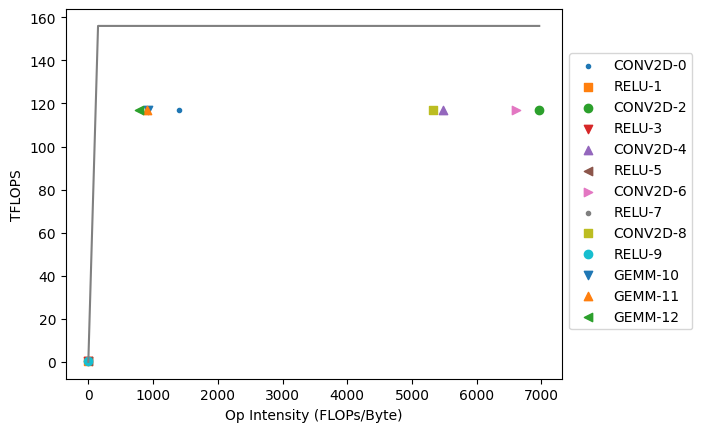

In [9]:

alexnet_on_a100_df = analysis_model(alexnet(256), A100_GPU)
display(alexnet_on_a100_df)

dot_roofline(alexnet_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(alexnet_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(alexnet_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[256, 256, 2304, 768]",C,7.10,2283.93,1.98,2170610.39,231928.23,48.00,1.69,144.00,193.69,117.00,2170610.39,305820.60
1,GEMM,"[256, 256, 256, 768]",C,2.38,765.76,0.22,241178.93,25769.80,48.00,0.19,16.00,64.19,117.00,241178.93,101348.10
2,GEMM,"[256, 256, 768, 256]",C,2.38,765.76,0.22,241178.93,25769.80,16.00,0.19,48.00,64.19,117.00,241178.93,101348.10
3,GEMM,"[256, 256, 768, 768]",C,4.75,1527.05,0.66,723536.80,77309.41,48.00,0.56,48.00,96.56,117.00,723536.80,152466.23
4,ADD,"[256, 256, 768]",M,0.00,0.67,0.21,227367.11,50.33,48.00,48.00,48.00,144.00,0.24,471.05,227367.11
5,GEMM,"[256, 256, 3072, 768]",C,7.57,2434.77,2.64,2894147.19,309237.65,48.00,2.25,192.00,242.25,117.00,2894147.19,382497.79
6,RELU,"[256, 786432]",M,0.00,1.00,0.55,606312.29,201.33,192.00,0.00,192.00,384.00,0.36,1884.21,606312.29
7,GEMM,"[256, 256, 768, 3072]",C,7.57,2434.77,2.64,2894147.19,309237.65,192.00,2.25,48.00,242.25,117.00,2894147.19,382497.79
8,ADD,"[256, 256, 768]",M,0.00,0.67,0.21,227367.11,50.33,48.00,48.00,48.00,144.00,0.24,471.05,227367.11


Total Cycles:10225845.96, Total data (MB): 1575.12


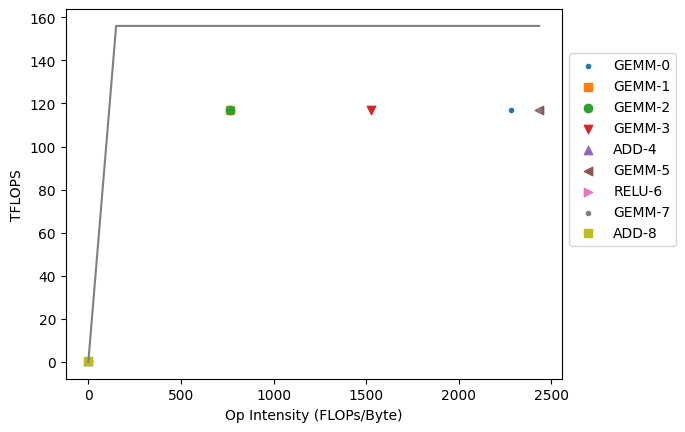

In [10]:
bert_on_a100_df = analysis_model(bert(256), A100_GPU)
display(bert_on_a100_df)
dot_roofline(bert_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(bert_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(bert_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

In [11]:
alexnet_on_a100_df.to_csv('output_a3i.csv', index=False)
bert_on_a100_df.to_csv('output_a3ii.csv', index=False)

## A.4 Compare on different Hardwares

### TODO A.4.i
Generate csv for alexnet and bert on jetson nano system, with batch size 4. <br>
Make sure to name the csv file 'output_a4i.csv' and 'output_a4ii.csv'

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,CONV2D,"[4, 96, 3, 224, 224, 11, 11]",C,1.13,1405.53,1.65,1028548.97,13988.27,0.57,0.03,18.38,18.98,8.50,1028548.97,908703.49
1,RELU,"[4, 279936]",M,0.00,1.00,0.16,102239.50,1.12,1.07,0.00,1.07,2.14,0.01,82.33,102239.50
2,CONV2D,"[4, 256, 96, 54, 54, 5, 5]",C,4.89,6073.02,1.69,1053876.71,14332.72,1.07,0.59,2.85,4.50,8.50,1053876.71,215488.32
3,RELU,"[4, 173056]",M,0.00,1.00,0.10,63204.30,0.69,0.66,0.00,0.66,1.32,0.01,50.90,63204.30
4,CONV2D,"[4, 384, 256, 26, 26, 3, 3]",C,2.95,3658.98,0.56,351812.67,4784.65,0.66,0.84,0.99,2.49,8.50,351812.67,119396.28
5,RELU,"[4, 55296]",M,0.00,1.00,0.03,20195.46,0.22,0.21,0.00,0.21,0.42,0.01,16.26,20195.46
6,CONV2D,"[4, 384, 384, 12, 12, 3, 3]",C,1.39,1728.00,0.18,112413.52,1528.82,0.21,1.27,0.21,1.69,8.50,112413.52,80781.82
7,RELU,"[4, 55296]",M,0.00,1.00,0.03,20195.46,0.22,0.21,0.00,0.21,0.42,0.01,16.26,20195.46
8,CONV2D,"[4, 256, 384, 12, 12, 3, 3]",C,1.31,1626.35,0.12,74942.34,1019.22,0.21,0.84,0.14,1.20,8.50,74942.34,57220.46
9,RELU,"[4, 36864]",M,0.00,1.00,0.02,13463.64,0.15,0.14,0.00,0.14,0.28,0.01,10.84,13463.64


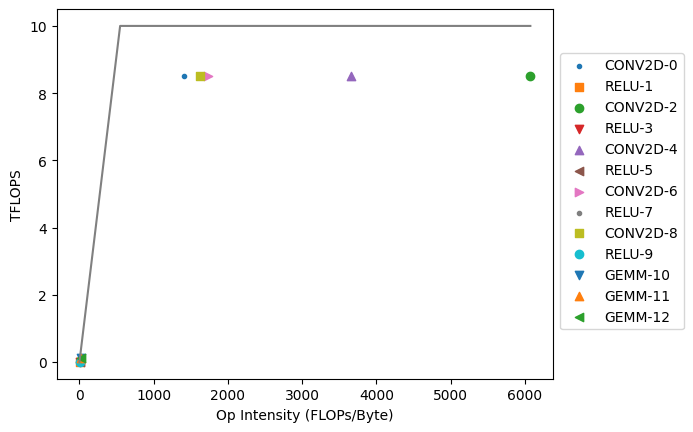

In [12]:
alexnet_on_jetson_nano_df = analysis_model(alexnet(4), jetson_nano)
display(alexnet_on_jetson_nano_df)
dot_roofline(alexnet_on_jetson_nano_df, jetson_nano)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[4, 256, 2304, 768]",C,1.19,1474.56,0.43,266461.67,3623.88,0.75,1.69,2.25,4.69,8.50,266461.67,224393.96
1,GEMM,"[4, 256, 256, 768]",M,0.52,646.74,0.09,56846.47,402.65,0.75,0.19,0.25,1.19,4.43,29606.85,56846.47
2,GEMM,"[4, 256, 768, 256]",M,0.52,646.74,0.09,56846.47,402.65,0.25,0.19,0.75,1.19,4.43,29606.85,56846.47
3,GEMM,"[4, 256, 768, 768]",M,0.90,1117.09,0.16,98733.34,1207.96,0.75,0.56,0.75,2.06,7.65,88820.56,98733.34
4,ADD,"[4, 256, 768]",M,0.00,0.67,0.17,107709.10,0.79,0.75,0.75,0.75,2.25,0.00,57.83,107709.10
5,GEMM,"[4, 256, 3072, 768]",C,1.24,1536.00,0.57,355282.22,4831.84,0.75,2.25,3.00,6.00,8.50,355282.22,287224.26
6,RELU,"[4, 786432]",M,0.00,1.00,0.46,287224.26,3.15,3.00,0.00,3.00,6.00,0.01,231.30,287224.26
7,GEMM,"[4, 256, 768, 3072]",C,1.24,1536.00,0.57,355282.22,4831.84,3.00,2.25,0.75,6.00,8.50,355282.22,287224.26
8,ADD,"[4, 256, 768]",M,0.00,0.67,0.17,107709.10,0.79,0.75,0.75,0.75,2.25,0.00,57.83,107709.10


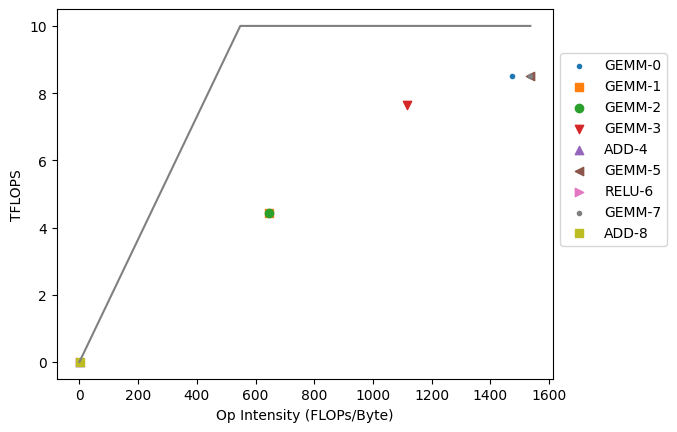

In [13]:
bert_on_jetson_nano_df = analysis_model(bert(4), jetson_nano)
display(bert_on_jetson_nano_df)
dot_roofline(bert_on_jetson_nano_df, jetson_nano)

alexnet_on_jetson_nano_df.to_csv('output_a4i.csv', index=False)
bert_on_jetson_nano_df.to_csv('output_a4ii.csv', index=False)

### TODO A.4.ii

Comment on the change in operator behavior between systems? Do they change, if so why?

1.The only bound change happens to the layer: GEMM-10,11,12. This is because these layers had a small difference in terms of their memory cycles and computation cycles when run on A100 (all are computation bounded). However, when we change the chip to jetson_nano, there is a large decrease on the BW compared to A100 (4 times decrease of that of flops decrease). Thus, the memory cycles larges increases, leading to memory bound on these operators on jetson_nano.

2.The chip efficiency increased, that's why when they reach the computaion cap, their are closer to the roof of the roofline model than the A100 model.

### TODO A.4.iii

For running alexnet, what changes would you suggest to on hardware specs that would help in optimizing the performance?

For alexnet, which is a relatively complex model which involves large data transfer and computation. I would say enhancing the chip memory bandwidth and the flops would help optimize its performance.